In [1]:
import sys  ###occlusion_free_mcl
sys.path.append('../scripts/')
from mcl import *

In [2]:
class OcclusionFreeParticle(Particle): 
    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]
            
            ##パーティクルの位置と地図からランドマークの距離と方角を算出##
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.relative_polar_pos(self.pose, pos_on_map)
            
            ##尤度の計算##
            distance_dev = distance_dev_rate*particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2])) #ここまでParticleクラスと同じ実装
            if obs_pos[0] < particle_suggest_pos[0]:
                self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(obs_pos)
            else: #距離の分布の中心を計測値に入れ替えて距離の誤差が大きくても尤度が低くならないようにする
                self.weight *= multivariate_normal(mean=[obs_pos[0], particle_suggest_pos[1]], cov=cov).pdf(obs_pos)

<IPython.core.display.Javascript object>


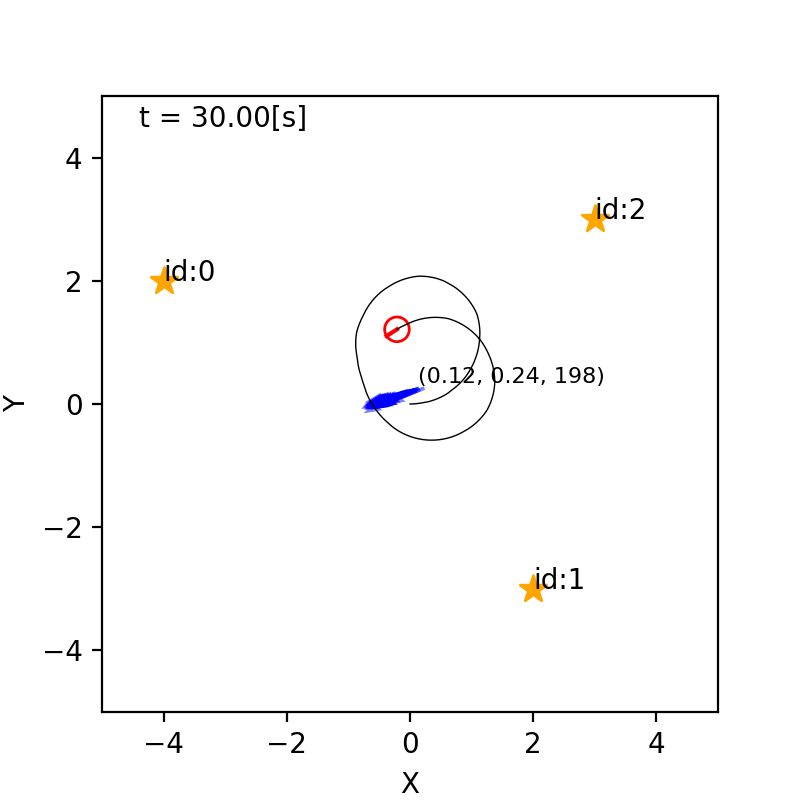

In [3]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ## ロボットを作る ##  ###occlusion_free_mclexec
    initial_pose = np.array([0, 0, 0]).T
    pf = Mcl(m, initial_pose, 100)
#    pf.particles = [OcclusionFreeParticle(initial_pose, 1.0/100) for i in range(100)] #OcclusionFreeParticleをMclに使わせる
    circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(initial_pose, sensor=Camera(m, occlusion_prob=0.5), agent=circling, color="red")
    world.append(r)
    world.draw()
    world.ani.save('/tmp/anm.gif', writer='imagemagick', fps=1)